## 1. Autoencoder
* Reference. https://dacon.io/codeshare/4551
* FashionMNIST dataset

#### (1) Extract latent vectors & Reconstruct image w/ Autoencoder (AE)

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [2]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

## 학습 데이터 10번 셋팅
## 각 단계별 64개로 설정
## cpu 사용

Using Device: cpu


In [3]:
trainset = datasets.FashionMNIST(
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2)

## datasets.FashionMNIST 데이터를 가지고 오겠다
## root -> 저장 장소
## train = true : train dataset을 가져오겠댜
## download = true : 저장장소에 데이터가 없으면 다운로드 하겠다
## transforms.ToTensor() -> 이미지 데이터를 (0,1)로 표현

## torch.utils.data.DataLoader : dataset을 배치 단위로 표현
## dataset = trainset (data 지정)
## shuffle =true : 데이터 셔플, 섞어주겠다
## 서브 프로세스 수를 2로 지정

100%|██████████| 26421880/26421880 [00:09<00:00, 2707915.99it/s]


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 366200.71it/s]


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6326571.09it/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13453132.08it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder (input: 28*28 image -> 3 as a latent vector)
        ## encoder :  입력 이미지를 작은 차원으로 줄여나간다
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            ## activation function = ReLU
            nn.Linear(128, 64),
            ## 128 -> 64
            nn.ReLU(),
            nn.Linear(64, 12),
            ## 64 -> 12
            nn.ReLU(),
            nn.Linear(12, 3),)
            ## 12 -> 3

        # Decoder (from latent vector (size: 3) -> decode it to 28*28 size image)
        ## decoder = latent vector를 다시 원래 차원으로 복원
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            ## 3 -> 12
            nn.ReLU(),
            nn.Linear(12, 64),
            #3 12 -> 64
            nn.ReLU(),
            nn.Linear(64, 128),
            ## 64 -> 128
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),)
            ## activation function = Sigmoid ,,  [0,1]

    def forward(self, x):
      ## encoder와 decoder를 받아주는 forward pass
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()
## criterion -> mse 손실 함수 참조

In [6]:
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [7]:
def train(autoencoder, train_loader):
    autoencoder.train()
    ## 학습모델로 전환
    for step, (x, label) in enumerate(train_loader):
      ## x 와 label로 구성된 데이터
        x = x.view(-1, 28*28).to(DEVICE)
        ## x는 28*28 크기에 DEVICE에 저장
        y = x.view(-1, 28*28).to(DEVICE)
        ## y도 x와 똑같이
        label = label.to(DEVICE)
        ## label 데이터도 DEVICE에 저장
        encoded, decoded = autoencoder(x)
        ## encode -> decode

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        ## 거꾸로 학습해서 매개체를 업데이트
        optimizer.step()

[Epoch 1]


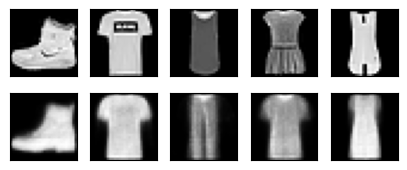

[Epoch 2]


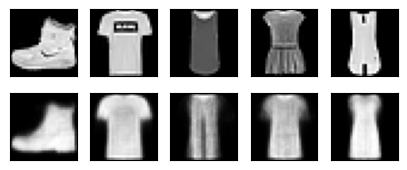

[Epoch 3]


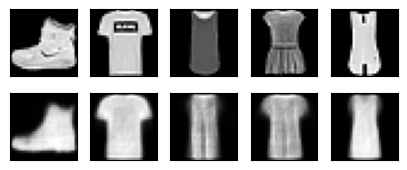

[Epoch 4]


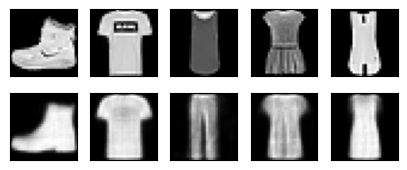

[Epoch 5]


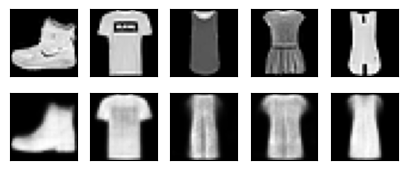

[Epoch 6]


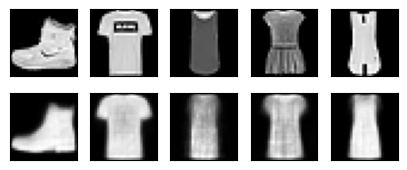

[Epoch 7]


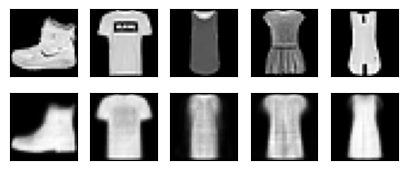

[Epoch 8]


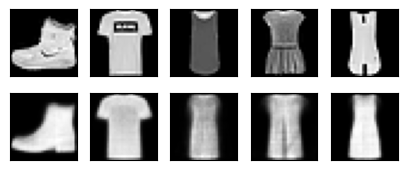

[Epoch 9]


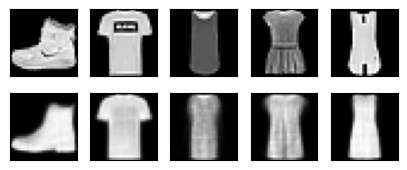

[Epoch 10]


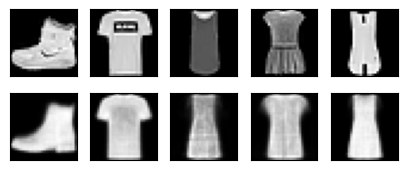

In [8]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)
    ## epoch train 반복문

    test_x = view_data.to(DEVICE)
    ## test_x를 지정된 장소에 저장하는데 테스트 데이터도 포함시킨다
    _, decoded_data = autoencoder(test_x)
    ## encoding된 데이터는 _로 무시하고 decoding된 데이터만 decoded_data

    f, a = plt.subplots(2, 5, figsize=(5, 2))
    ## 2*5 subplot 격자 생성하고
    print("[Epoch {}]".format(epoch))
    ## 복원된 이미지를 각 epoch마다 시각화한다
    for i in range(5):
      ## 처음으로 5개의 이미지
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        ## 28*28 크기로 reshape
        a[0][i].imshow(img, cmap='gray')
        ## gray 색으로 표현
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

#### (2) Image Denoising w/ AE

In [9]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    ## 똑같은 사이즈의 noise를 생성하고
    noisy_img = img + noise
    ## noise를 image에 심는다.
    return noisy_img

def train(autoencoder, train_loader):
    autoencoder.train()
    ## 모델을 학습 모드로 전환
    avg_loss = 0
    ## 평균 손실을 0으로 설정
    for step, (x, label) in enumerate(train_loader):
      ## 배치 단위로 데이터 가져와
        noisy_x = add_noise(x)
        ## x에 노이즈 추가
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        ## 28*28 사이즈로 저장
        y = x.view(-1, 28*28).to(DEVICE)
        ## 1차원 벡터로 전환 후 저장

        label = label.to(DEVICE)
        ## label 데이터를 지정된 장소로 옮김
        encoded, decoded = autoencoder(noisy_x)
        ## encode -> decode

        loss = criterion(decoded, y)
        ## 오차 계산
        optimizer.zero_grad()
        ## 이전 배치의 오차를 전부 0으로 환산
        loss.backward()
        ## back process optimizer
        optimizer.step()

        avg_loss += loss.item()
        ## 손실 누적
    return avg_loss / len(train_loader)
    ## 손실 누적 평균 계산하여 반환

for epoch in range(1, EPOCH+1):
  ## epoch 수만큼 for 반복문
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

In [10]:
testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False, # Unseen test dataset
    download  = True,
    transform = transforms.ToTensor())
## testset 로드하고 존재하지 않으면 다운로드
## 이미지를 tensor로 변환

sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.
## test data 1차원 벡터로 변환
## floattenor로 변환하고 / 255로 나눈다/ [0,1]내의 정규화

original_x = sample_data[0]
## 원본_x
noisy_x = add_noise(original_x).to(DEVICE)
## noise추가_x
_, recovered_x = autoencoder(noisy_x)
## encoding된 데이터:_ / decoding된 데이터:recovered_x

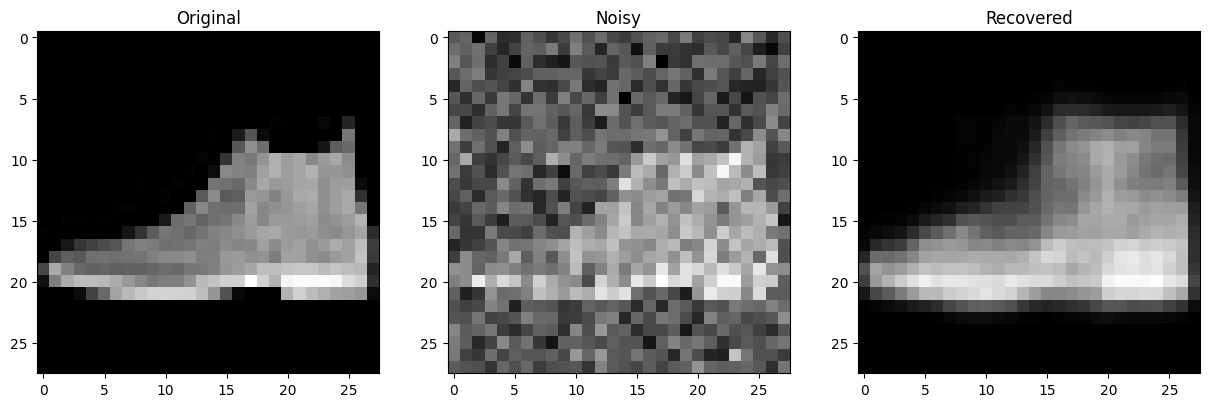

In [11]:
f, a = plt.subplots(1, 3, figsize=(15, 15))
## f:전체 피규어 객체, a:서브플롯 배열

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))
## 28*28 크기로 원본 이미지 변환, cpu로 이동
## 노이즈 이미지를 28*28로 다시 변환, cpu로 이동
## 복원된 이미지 28*28로 다시 변환, cpu로 이동

# original image
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')
## 제목, 회색

# original image w/ noise
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# recoveredimage
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

### Question 1. Explain the code of the '1. Autoencoder' section "briefly".

(완)

.

## 2. Principal Component Analysis [PCA]
* reference. https://romg2.github.io/mlguide/12_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-06.-%EC%B0%A8%EC%9B%90%EC%B6%95%EC%86%8C-PCA/

### Question 2. What is PCA in "mathematical" perspective? Google it and write your own answer.

데이터의 분산을 최대한 유지하면서 저차원으로 변환하는 과정. 공분한 행렬의 고유값 분해를 통해 데이터를 설명하는 중요한 축을 찾아내어 차원을 축소한다. -> curse of dimensionality를 해결

In [12]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

In [15]:
from sklearn.datasets import load_iris

iris = load_iris()

columns = ['sepal_length','sepal_width','petal_length','petal_width']
iris_df = pd.DataFrame(data = iris.data, columns = columns)
iris_df["target"] = iris.target

iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


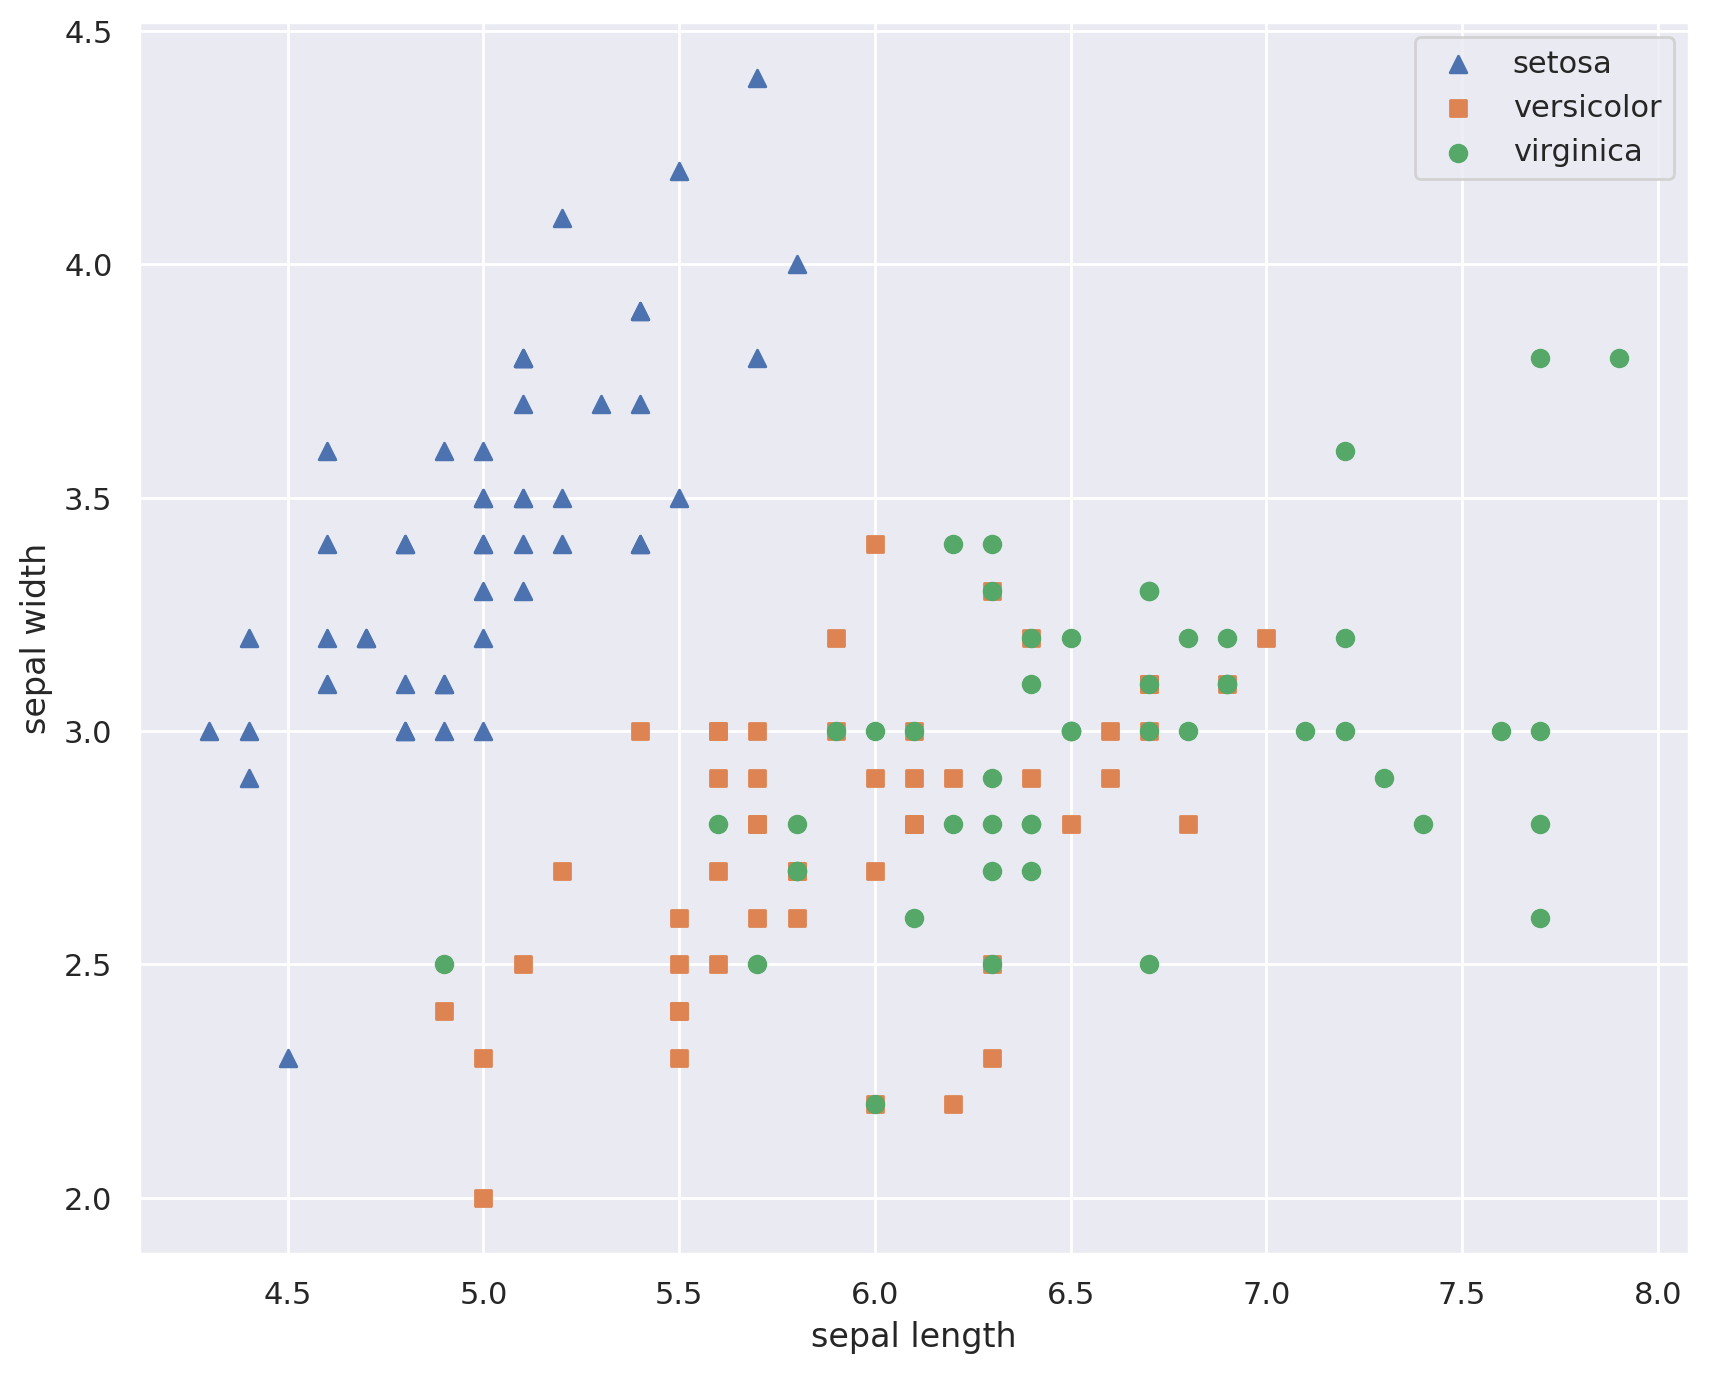

In [16]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df[iris_df['target']==i]['sepal_length']
    y_axis_data = iris_df[iris_df['target']==i]['sepal_width']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [17]:
from sklearn.preprocessing import StandardScaler

iris_f_scaled = StandardScaler().fit_transform(iris_df.iloc[:,:-1])

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # of principal components = 2

pca.fit(iris_f_scaled)
iris_pca = pca.transform(iris_f_scaled)

print(f"scaled: {iris_f_scaled.shape}")
print(f"pca: {iris_pca.shape}")

scaled: (150, 4)
pca: (150, 2)


In [19]:
pca_columns=['pca_component_1','pca_component_2']

iris_df_pca = pd.DataFrame(iris_pca, columns = pca_columns)
iris_df_pca['target'] = iris.target

iris_df_pca.head(3)

,pca_component_1,pca_component_2,target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0


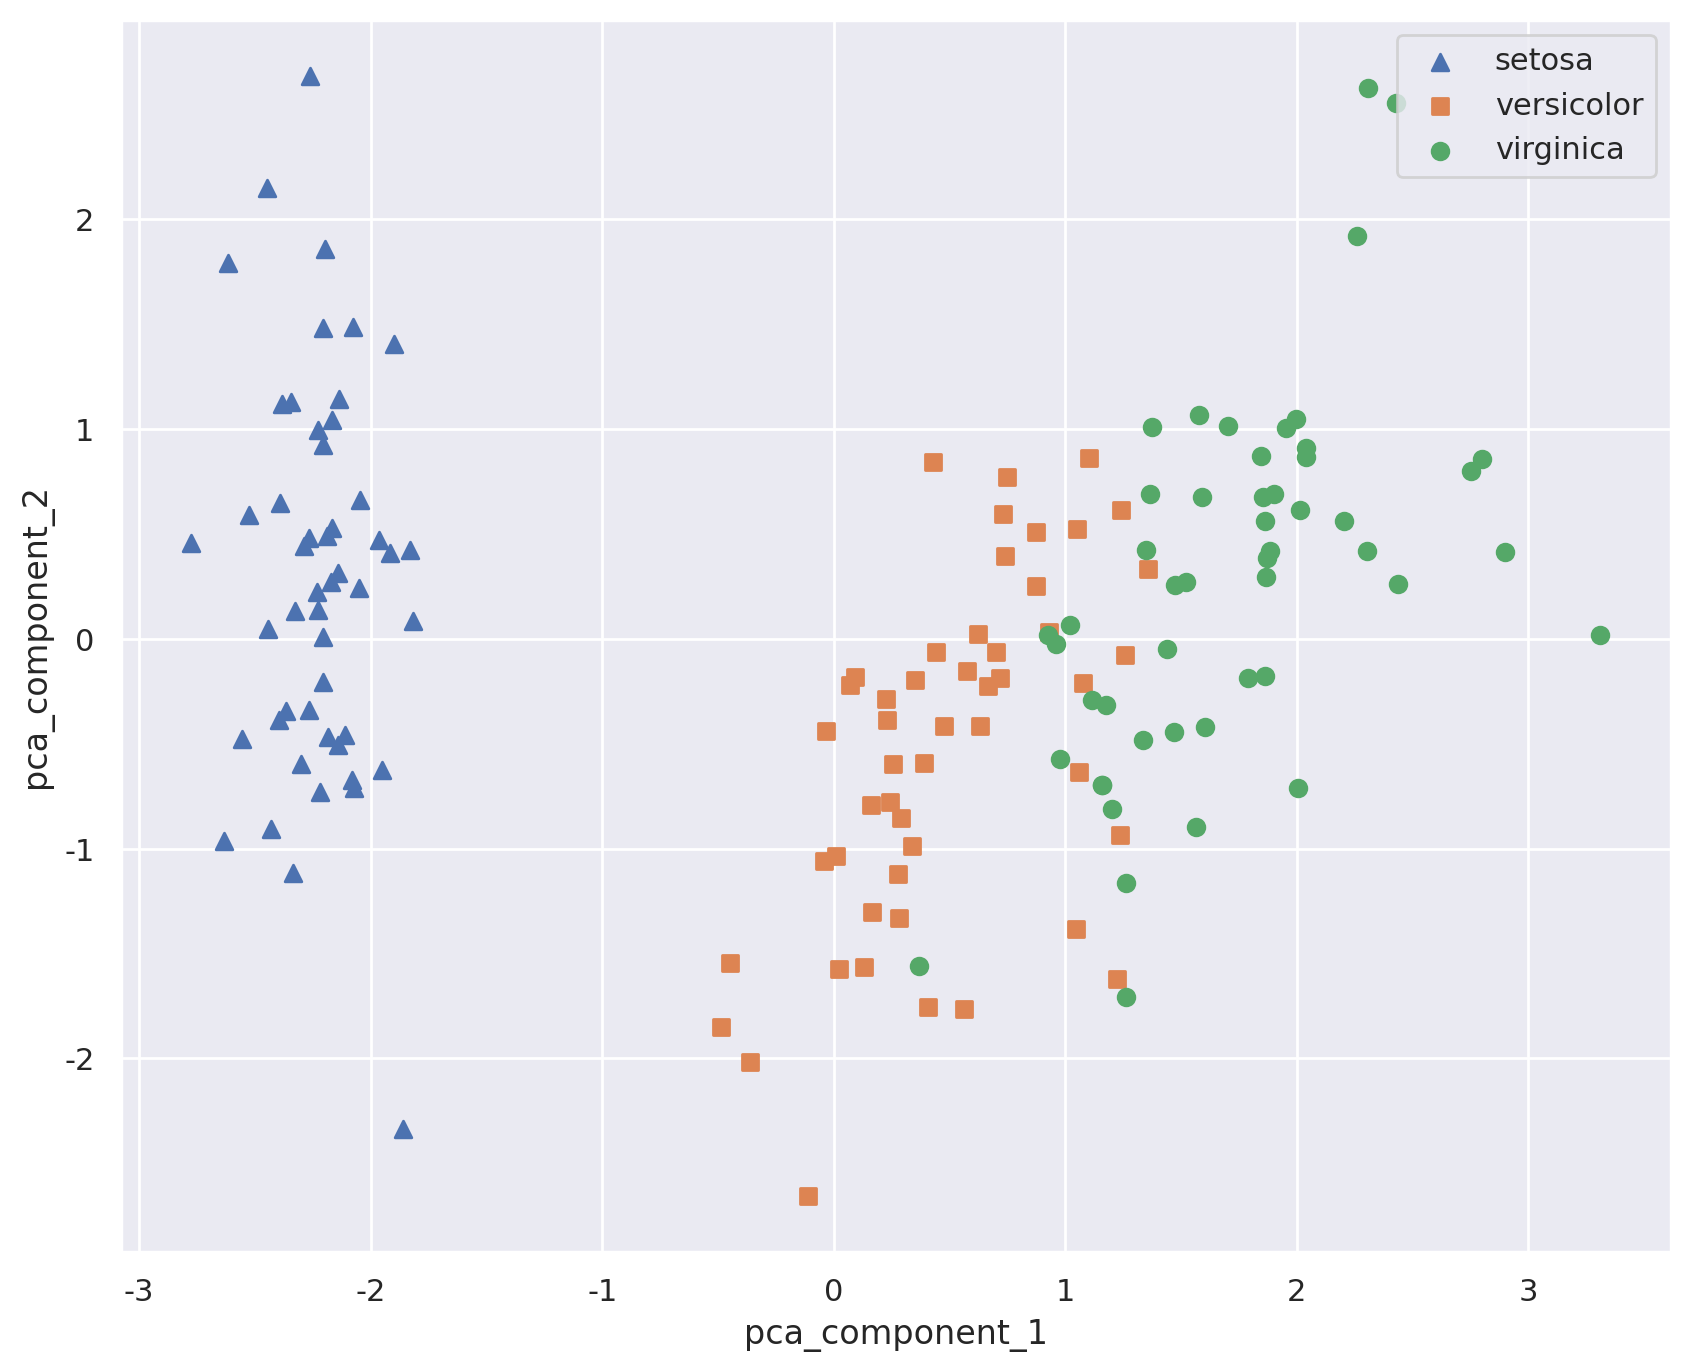

In [20]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_1']
    y_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

In [21]:
print(pca.explained_variance_ratio_) ## Although we implemented PCA, we can still explain majority of the data


[0.72962445 0.22850762]


.

## 3. Variational Autoencoder (VAE)
Question 4 (Optional).

Read the following document, run the whole code and write an explanation.

https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

## Implementation of Variational AutoEncoder (VAE)

*VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)

 *Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)

 *Author-email:  mskang@handong.edu

 *python and pytorch version: python=3.7, pytorch=1.3.1

In [22]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [23]:
 # Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

### Step 1. Load (or download) Dataset

In [24]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [25]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [26]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [27]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [28]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

nvida cuda driver설치했는데도 계속 오류가 떠요

### Step 3. Define Loss Function and optimizer

In [29]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

NameError: name 'model' is not defined

### Step 4. Train VAE

In [12]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...


NameError: name 'model' is not defined

### Step 5. Generate images from test dataset

In [13]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

NameError: name 'model' is not defined

In [14]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

show_image(x_hat, idx=0)

NameError: name 'x_hat' is not defined

### Step 6. Generate image from noise vector

In [15]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

show_image(generated_images, idx=12)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

.

## 4. Seq2Seq, Attention, Transformer

Question 4 (Optional).

Choose one of the following document. Read it, run the whole code and write and explanation.

(1) Machine Translation using Attention and Seq2Seq: https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html

(2) Understanding Transformer: https://wikidocs.net/156986

(3) Chatbot based on Text Similarity (Transformer): https://wikidocs.net/157970

## (2) Understanding Transformer: https://wikidocs.net/156986

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import pandas as pd
import random
import re

from torch.utils.data import DataLoader, Dataset

In [31]:
## 기본 transformer 구조
class Transformer(nn.Module):
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, ):
        super().__init__()

        # Layers
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )

    def forward(self):
        pass

## transformer의 주요 파라미터(복붙한거. 정리한거 아님)

## d_model - 트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기를 의미합니다. (default=512)
## num_encoder_layers - 트랜스포머 모델에서 인코더가 총 몇 층으로 구성되었는지를 의미합니다. (default=6)
## num_decoder_layers - 트랜스포머 모델에서 디코더가 총 몇 층으로 구성되었는지를 의미합니다. (default=6)
## nhead – 멀티헤드 어텐션 모델의 헤드 수, 어텐션을 사용할 때 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식에서 병렬의 수 (default=8)
## dim_feedforward – feedforward network model 의 차원, 피드 포워드 신경망의 은닉층의 크기(default=2048)

In [32]:
## positional encoding

## transformer는 입력 순서를 상관치 않기 때문에 '순서 정보'를 주입할 필요가 있음
## -> '위치에 따른','중요도 부여' -- (상대적인, 절대적인 위치의 정보)
## ==> 위치를 나타내는 각 요소에 대한 벡터를 생성한다는 것

class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # 드롭 아웃
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)

        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        ###  using regeister_buffer()
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
    ## state_dict()로 확인 가능, GPU연산 가능

In [34]:
## padding masking
## tensor 는 모두 같은 크기의 행렬
## -> (start)(end) 같은 특수 토큰들 -> 정수ID로 변환
## --> 토큰이 있는 위치:True, 없으면:False로 이진 행렬

class Transformer(nn.Module):
    # Constructor
    def __init__( self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=5000)
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src, Tgt size 는 반드시 (batch_size, src sequence length) 여야 합니다.

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)


In [35]:
## 패딩이 필요하지 않도록 크기가 8인 모든 문장을 만들고 크기가 16인 배치로 무작위로 구성

def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

#크기가 16인 배치 형태로 만들어 줍니다.
def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # batch_size 크기가 아닌 경우 마지막 비트를 얻지 않도록 합니다.
        if idx + batch_size < len(data):
            # 여기서 배치의 최대 길이를 가져와 PAD 토큰으로 길이를 정규화해야 합니다.
            if padding:
                max_batch_length = 0
                # batch에서 가장 긴 문장 가져오기
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # 최대 길이에 도달할 때까지 X 패딩 토큰을 추가합니다.
                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

562 batches of size 16
187 batches of size 16


In [37]:
## 훈련 및 검증

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [38]:
## (1)target tensor는 예측 중에 모델에 전달
## (2)다음 단어를 숨기기 위해 target mask 생성
## (3)padding mask가 생성되어 모델에 전달

def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # 이제 tgt를 1만큼 이동하여 <SOS>를 사용하여 pos 1에서 토큰을 예측합니다.
        y_input = y[:,:-1]
        y_expected = y[:,1:]

        # 다음 단어를 마스킹하려면 마스크 가져오기
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # X, y_input 및 tgt_mask를 전달하여 표준 training
        pred = model(X, y_input, tgt_mask)

        # Permute 를 수행하여 batch size 가 처음이 되도록
        pred = pred.permute(1, 2, 0)
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [41]:
## validation

def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            y_input = y[:,:-1]
            y_expected = y[:,1:]

            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            pred = model(X, y_input, tgt_mask)

            pred = pred.permute(1, 2, 0)
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [42]:
## 훈련 및 검증 실행

def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    # 나중에 plotting 하기위해
    train_loss_list, validation_loss_list = [], []

    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)

        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]

        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()

    return train_loss_list, validation_loss_list

train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)

## 결과를 보면 loss가 감소하는 것을 볼 수 있다

Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.5825
Validation loss: 0.4070

------------------------- Epoch 2 -------------------------
Training loss: 0.4107
Validation loss: 0.3715

------------------------- Epoch 3 -------------------------
Training loss: 0.3778
Validation loss: 0.3227

------------------------- Epoch 4 -------------------------
Training loss: 0.3352
Validation loss: 0.2550

------------------------- Epoch 5 -------------------------
Training loss: 0.2973
Validation loss: 0.2287

------------------------- Epoch 6 -------------------------
Training loss: 0.2735
Validation loss: 0.1979

------------------------- Epoch 7 -------------------------
Training loss: 0.2554
Validation loss: 0.1793

------------------------- Epoch 8 -------------------------
Training loss: 0.2421
Validation loss: 0.1922

------------------------- Epoch 9 -------------------------
Training loss: 0.2344
Validation loss: 0.1651

-------

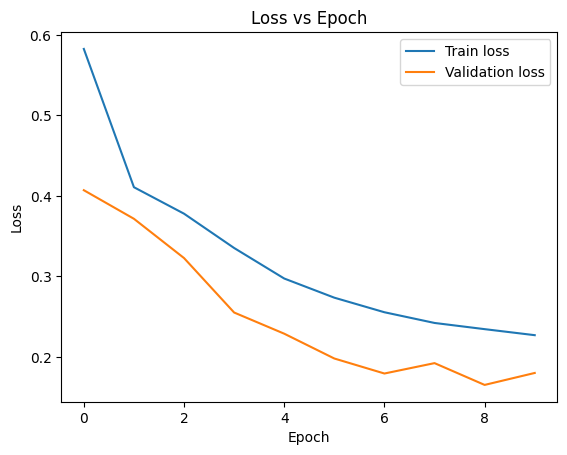

In [44]:
plt.plot(train_loss_list, label = "Train loss")
plt.plot(validation_loss_list, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [45]:
## inference

def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    model.eval()

    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

        pred = model(input_sequence, y_input, tgt_mask)

        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()


# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()


Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 5
Input: [0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

